# Retrieving Biomarkers from JSON file 

### Pre-Merge

In [144]:
import json

input_file = 'relational_results/rel_ner_results_deepseek_70b.jsonl'
# output_file = 'sorted_file_v2.jsonl'

# Read all JSON lines
with open(input_file, 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]


In [145]:
data_sorted = sorted(data, key=lambda x: x['subject'])

In [146]:
len(data_sorted)

12129

### Removing Extraneous

In [147]:
import pandas as pd

data = pd.DataFrame(data_sorted, columns=['article', 'subject', 'relationship', 'object', 'chunk'])

In [148]:
data

,article,subject,relationship,object,chunk
0,PMC6879435.txt,11C-(R)-PK11195,USED_TO_DIAGNOSE,Diagnose: Alzheimer's Disease,4
1,PMC6879435.txt,11C-DAA1106,USED_TO_DIAGNOSE,Alzheimer's Disease,5
2,PMC6879435.txt,11C-DED,USED_TO_DIAGNOSE,Astrocytosis in Alzheimer's Disease,7
3,PMC6879435.txt,11C-DED,INDICATES_PRESENCE_OF,Astrocytosis in early stages of Alzheimer's Di...,7
4,PMC6879435.txt,11C-PBR28,INDICATES_PRESENCE_OF,Alzheimer's Disease,5
...,...,...,...,...,...
12124,PMC4611062.txt,δ−α2,USED_TO_DIAGNOSE,Diagnose: Mild Cognitive Impairment (MCI) rela...,10
12125,PMC4611062.txt,θ−α2,USED_TO_DIAGNOSE,Diagnose: Mild Cognitive Impairment (MCI) rela...,10
12126,PMC4611062.txt,θ−β1,USED_TO_DIAGNOSE,Diagnose: Mild Cognitive Impairment (MCI) rela...,10
12127,PMC4611062.txt,θ−γ,USED_TO_DIAGNOSE,Diagnose: Mild Cognitive Impairment (MCI) rela...,10


In [149]:
sub = data[data['relationship'] == 'INDICATES_PRESENCE_OF']
sub

,article,subject,relationship,object,chunk
3,PMC6879435.txt,11C-DED,INDICATES_PRESENCE_OF,Astrocytosis in early stages of Alzheimer's Di...,7
4,PMC6879435.txt,11C-PBR28,INDICATES_PRESENCE_OF,Alzheimer's Disease,5
5,PMC6879435.txt,11C-PiB,INDICATES_PRESENCE_OF,Presence: Aβ deposition in Alzheimer's Disease,4
15,PMC6023430.txt,129Xe,INDICATES_PRESENCE_OF,Alzheimer's Disease,5
19,PMC9314594.txt,129Xe signal in gray matter,INDICATES_PRESENCE_OF,Alzheimer's Disease,8
...,...,...,...,...,...
12104,PMC9972756.txt,β-amyloid (Aβ),INDICATES_PRESENCE_OF,Alzheimer's Disease,1
12108,PMC9962062.txt,β-amyloid proteins,INDICATES_PRESENCE_OF,Presence: Alzheimer's Disease,14
12110,PMC7067577.txt,β-catenin,INDICATES_PRESENCE_OF,Alzheimer's Disease,3
12111,PMC2731764.txt,β-hydroxybutyrate,INDICATES_PRESENCE_OF,Therapeutic response to AC-1202 in Alzheimer's...,1


In [150]:
objects = list(sub['object'].unique())

### Merged

In [151]:
from collections import defaultdict
grouped = defaultdict(list)

for entry in data_sorted:
    subject = entry['subject']
    relation = {
        'article' : entry['article'],
        'relationship': entry['relationship'],
        'object': entry['object']
    }
    grouped[subject].append(relation)


In [152]:
import pandas as pd
df = pd.DataFrame({'Biomarker': list(grouped.keys()), 'Relations': list(grouped.values())})
df = df[~df['Relations'].isin([[], ''])]


In [61]:
len(df)

4643

In [62]:
biomarkers = df['Biomarker'].to_list()

In [65]:
# pip install sentence-transformers scikit-learn
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl.metadata (24 kB)
Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)


In [66]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

# Step 1: Embed the entities
model = SentenceTransformer("all-MiniLM-L6-v2")  # Small and efficient model
embeddings = model.encode(biomarkers)

# Step 2: Choose number of clusters (elbow method or trial & error)
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)  # adjust threshold
labels = clustering.fit_predict(embeddings)

# Step 3: View results
df_clustered = pd.DataFrame({'Entity': biomarkers, 'Cluster': labels})
df_clustered = df_clustered.sort_values(by='Cluster')
print(df_clustered)


2025-05-03 14:40:19.020788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-03 14:40:20.258860: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 14:40:35.854921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-05-03 14:40:35.855070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

                         Entity  Cluster
57                          2HG        0
1855                        HT7        0
1856                        HVA        0
2398                        Mer        0
1863                         Hb        0
...                         ...      ...
4164              gait velocity      703
3263            Slow gait speed      703
1716                 Gait Speed      703
1834  HLA-DR surface expression      704
873     CD39 surface expression      704

[4643 rows x 2 columns]


In [67]:
df_clustered.to_csv('clusters.csv')

In [67]:
df_clustered

,Entity,Cluster
1047,Cognitive function (ADAS-cog),0
1053,Cognitive score,0
1054,Cognitive scores (ADAS-Cog11),0
1055,Cognitive scores (MMSE),0
1056,"Cognitive tasks (visual oddball, flanker, n-ba...",0
...,...,...
1955,Left IFG orbitalis,631
1280,ELoc,632
1309,Eloc,632
1632,HLA-DR surface expression,633


In [75]:
merged_some = pd.DataFrame(pd.read_csv('clusters.csv', index_col=0))

In [76]:
df_merged = merged_some.sort_values(by='Cluster', ascending=True)

In [77]:
df_merged.rename(columns={'Entity': 'Biomarker'}, inplace=True)

In [79]:
full_df = pd.merge(df, df_merged, on='Biomarker')

In [80]:
full_df.sort_values(by='Cluster', ascending=True)

,Biomarker,Relations,Cluster
1853,HVA,"[{'article': 'PMC5008228.txt', 'relationship':...",0
1825,HF,"[{'article': 'PMC8154928.txt', 'relationship':...",0
1841,HR,"[{'article': 'PMC8345445.txt', 'relationship':...",0
2395,Mer,"[{'article': 'PMC11274940.txt', 'relationship'...",0
64,4-HNE,"[{'article': 'PMC3978916.txt', 'relationship':...",0
...,...,...,...
1716,Gait speed,"[{'article': 'PMC4406069.txt', 'relationship':...",703
1718,Gait velocity,"[{'article': 'PMC4197903.txt', 'relationship':...",703
1719,Gait-speed,"[{'article': 'PMC4406069.txt', 'relationship':...",703
1831,HLA-DR surface expression,"[{'article': 'PMC6584558.txt', 'relationship':...",704


In [81]:
full_df.to_csv('full-df.csv')

### Soft Matching

In [75]:
pip install fuzzywuzzy python-Levenshtein

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.8/170.8 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [83]:
from fuzzywuzzy import fuzz

def soft_match_score_quadruple(q1, q2, threshold=85):
    a1, h1, r1, t1, c1= q1
    a2, h2, r2, t2, c2 = q2
    
    article_score = fuzz.ratio(a1,a2)
    head_score = fuzz.ratio(h1, h2)
    rel_score = fuzz.ratio(r1, r2)
    tail_score = fuzz.ratio(t1, t2)

    avg_score = (head_score + rel_score + tail_score + article_score) / 4
    return avg_score >= threshold

def compute_soft_metrics_quadruples(predicted_quads, gold_quads, threshold=85):
    matched = set()
    tp = 0

    for pred in predicted_quads:
        for i, gold in enumerate(gold_quads):
            if i in matched:
                continue
            if soft_match_score_quadruple(pred, gold, threshold):
                tp += 1
                matched.add(i)
                break

    fp = len(predicted_quads) - tp
    fn = len(gold_quads) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [48]:
ds32_path = 'relational_results/sorted_rel_ner_results_ds32.jsonl'
ds70_path = 'relational_results/sorted_rel_ner_results_ds70_subset.jsonl'
gemma_path = 'relational_results/sorted_rel_ner_results_gemma.jsonl'


# Read all JSON lines
with open(ds32_path, 'r', encoding='utf-8') as f:
    ds32 = [json.loads(line) for line in f]

with open(ds70_path, 'r', encoding='utf-8') as f:
    ds70 = [json.loads(line) for line in f]    
    
with open(gemma_path, 'r', encoding='utf-8') as f:
    gemma = [json.loads(line) for line in f]

In [53]:
compute_soft_metrics_quadruples(ds32, ds70)

{'true_positives': 4620,
 'false_positives': 1316,
 'false_negatives': 0,
 'precision': 0.7783018867924528,
 'recall': 1.0,
 'f1': 0.8753315649867375}

### later stuff

In [ ]:

# Write grouped output
with open(output_file, 'w', encoding='utf-8') as f:
    for subject, relations in grouped.items():
        out_entry = {'subject': subject, 'relations': relations}
        json.dump(out_entry, f)
        f.write('\n')

In [ ]:
# Read all JSON lines
with open(output_file, 'r', encoding='utf-8') as f:
    hmm = [json.loads(line) for line in f]

In [ ]:
for obj in hmm:
    print(obj['subject']) 

### cluster labels

In [3]:
import pandas as pd
full_df_read = pd.DataFrame(pd.read_csv('results-final/full-df.csv', index_col=0))

In [15]:
cluster_sorting = full_df_read.sort_values(by='Cluster', ascending=True) 

cols = ['Cluster'] + [col for col in cluster_sorting.columns if col != 'Cluster']
clustered = cluster_sorting[cols]

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering

# For each cluster, extract a reduced keyword from the grouped terms
def cluster_keywords(biomarkers):
    if len(biomarkers) == 1:
        return biomarkers[0].lower()
    
    vect = TfidfVectorizer(analyzer='word', stop_words='english')
    X = vect.fit_transform(biomarkers)
    
    clustering = AgglomerativeClustering(n_clusters=1).fit(X.toarray())
    return biomarkers[0].lower().split()[0]  # crude fallback keyword

cluster_groups = clustered.groupby("Cluster")["Biomarker"].apply(list)
cluster_labels = cluster_groups.apply(cluster_keywords).to_dict()
clustered["Cluster_Label"] = clustered["Cluster"].map(cluster_labels)


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [24]:
clustered.to_csv('final_df.csv')

### statistics

In [ ]:
import pandas as pd

df_stats = pd.DataFrame(pd.read_csv('results-final/full-df.csv', index_col=0))
df_stats['Cluster'].value_counts()

In [ ]:
dict(data['relationship'].value_counts())

In [ ]:
subj_obj = data[['subject', 'object']]
freqs = subj_obj.value_counts()
dict(freqs)

In [164]:
my_dict = dict(freqs)
most_freq = []
for val in my_dict.items():
    if val[1] > 10:
        most_freq.append(val)

In [165]:
most_freq

[(('Aβ', "Alzheimer's Disease"), 103),
 (('APOE4', "Alzheimer's Disease"), 87),
 (('Aβ42', "Alzheimer's Disease"), 82),
 (('Tau', "Alzheimer's Disease"), 53),
 (('Aβ', "Diagnose: Alzheimer's Disease"), 53),
 (('Aβ42', "Diagnose: Alzheimer's Disease"), 49),
 (('APOE ε4', "Alzheimer's Disease"), 47),
 (('MMSE', "Diagnose: Alzheimer's Disease"), 40),
 (('tau', "Alzheimer's Disease"), 35),
 (('Aβ40', "Alzheimer's Disease"), 34),
 (('IL-6', "Alzheimer's Disease"), 33),
 (('BDNF', "Alzheimer's Disease"), 32),
 (('t-tau', "Alzheimer's Disease"), 31),
 (('Aβ1–42', "Alzheimer's Disease"), 30),
 (('IL-1β', "Alzheimer's Disease"), 25),
 (('p-tau', "Alzheimer's Disease"), 24),
 (('p-tau181', "Alzheimer's Disease"), 23),
 (('Tau', "Diagnose: Alzheimer's Disease"), 22),
 (('Aβ40', "Diagnose: Alzheimer's Disease"), 22),
 (('APOE4', "Diagnose: Alzheimer's Disease"), 21),
 (('Aβ1–42', "Diagnose: Alzheimer's Disease"), 20),
 (('Aβ1-42', "Alzheimer's Disease"), 20),
 (('GFAP', "Alzheimer's Disease"), 19)

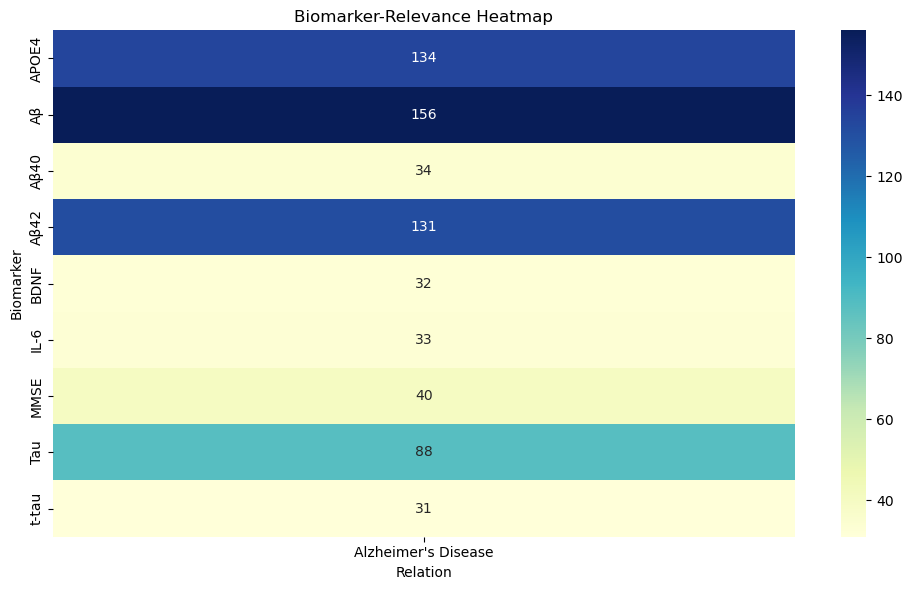

In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Your data
subj_obj_pairs  = [
    (('Aβ', "Alzheimer's Disease"), 156),
    (('APOE4', "Alzheimer's Disease"), 134),
    (('Aβ42', "Alzheimer's Disease"), 131),
    (('Tau', "Alzheimer's Disease"), 88),
    (('MMSE', "Alzheimer's Disease"), 40),
    (('Aβ40', "Alzheimer's Disease"), 34),
    (('IL-6', "Alzheimer's Disease"), 33),
    (('BDNF', "Alzheimer's Disease"), 32),
    (('t-tau', "Alzheimer's Disease"), 31)
]

# Create DataFrame
df_heatmap = pd.DataFrame(data, columns=['pair', 'count'])
df_heatmap[['biomarker', 'relation']] = pd.DataFrame(df_heatmap['pair'].tolist(), index=df.index)
df_heatmap = df_heatmap.drop(columns='pair')

# Pivot the data
pivot_df = df_heatmap.pivot(index='biomarker', columns='relation', values='count').fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.0f')
plt.title('Biomarker-Relevance Heatmap')
plt.ylabel('Biomarker')
plt.xlabel('Relation')
plt.tight_layout()
plt.show()